<a href="https://colab.research.google.com/github/sarkarbiswajit/Covid_Detection_Chest_xray/blob/main/covid_chest_xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import tensorflow as tf


import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()  # Choose the kaggle.json file that you downloaded


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"biswajitsarkar558","key":"8a1c80a324daf3bcb94ac0251d3ac720"}'}

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database


100% 777M/778M [00:11<00:00, 98.1MB/s]
100% 778M/778M [00:11<00:00, 72.2MB/s]


In [ ]:
!unzip covid19-radiography-database.zip


Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

In [ ]:
# label tagging to the images

levels = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
path = "/content/COVID-19_Radiography_Dataset"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level + '/images')):
        data.append(['{}/images/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'result'])

data['path'] = path + '/' + data['image_file']

data.head()

,image_file,result,path
0,Normal/images/Normal-3310.png,Normal,/content/COVID-19_Radiography_Dataset/Normal/i...
1,Normal/images/Normal-1648.png,Normal,/content/COVID-19_Radiography_Dataset/Normal/i...
2,Normal/images/Normal-3214.png,Normal,/content/COVID-19_Radiography_Dataset/Normal/i...
3,Normal/images/Normal-3340.png,Normal,/content/COVID-19_Radiography_Dataset/Normal/i...
4,Normal/images/Normal-3437.png,Normal,/content/COVID-19_Radiography_Dataset/Normal/i...


In [ ]:
print("Numbers of X-ray images: {}".format(data.shape[0]))

Numbers of X-ray images: 21165


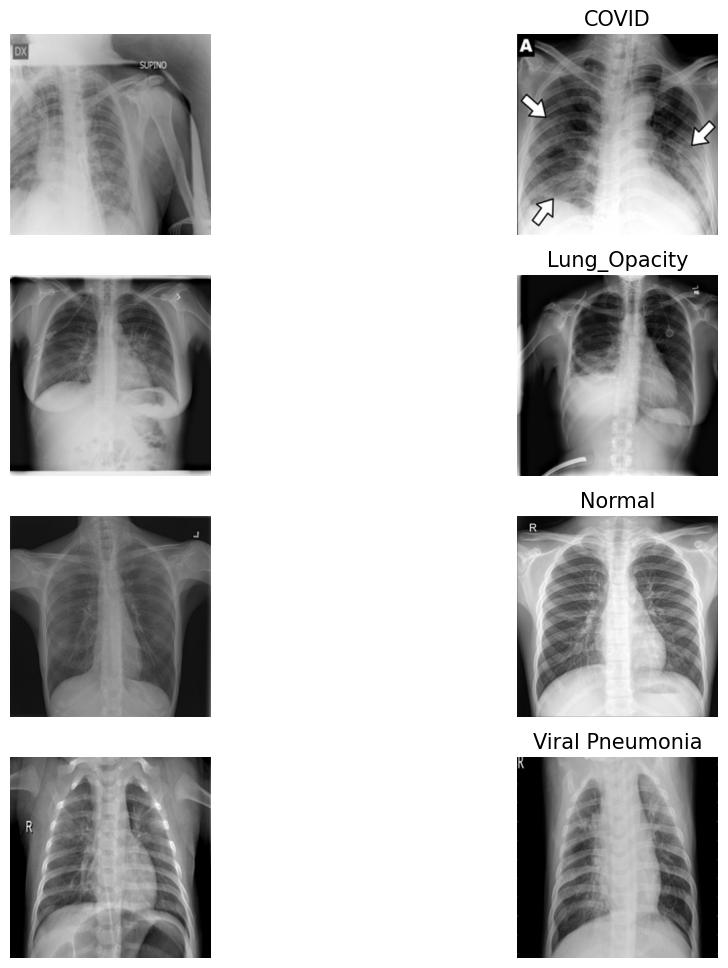

In [ ]:
n_samples = 2

fig, m_axs = plt.subplots(4, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['result']).groupby('result')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

<ipython-input-11-6e24529e5eb0>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  sx.set_xticklabels(labels=sx.get_xticklabels(), rotation=90)


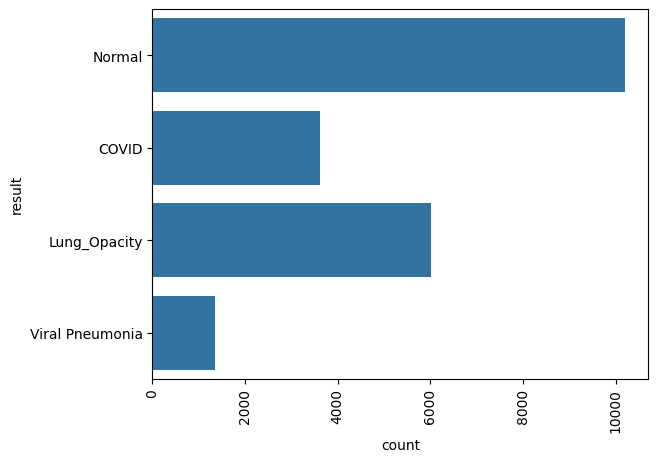

In [ ]:
sx = sns.countplot(data['result'])
sx.set_xticklabels(labels=sx.get_xticklabels(), rotation=90)
plt.show()


In [ ]:
print('Normal : ', list(data['result']).count('Normal'))
print('Covid : ', list(data['result']).count('COVID'))
print('Opacity : ', list(data['result']).count('Lung_Opacity'))
print('VIral Pneumonia : ', list(data['result']).count('Viral Pneumonia'))
#10192 images sont normales

Normal :  10192
Covid :  3616
Opacity :  6012
VIral Pneumonia :  1345


In [ ]:
round(data['result'].value_counts() / data.shape[0] * 100,2)

Normal             48.15
Lung_Opacity       28.41
COVID              17.08
Viral Pneumonia     6.35
Name: result, dtype: float64

In [ ]:
pixel_img = []

for image in tqdm(data['path']):
    img=Image.open(image)
    img=ImageOps.grayscale(img)
    img=img.resize((64,64))
    img=np.asarray(img)
    img=img.reshape((64,64,1))
    pixel_img.append(img)

100%|██████████| 21165/21165 [00:51<00:00, 413.90it/s]


In [ ]:
pixel_img = np.array(pixel_img)
label_img = data['result'].map({'Normal': 0, 'COVID': 1, 'Lung_Opacity' : 2,
                               'Viral Pneumonia' : 3})

print(pixel_img.shape, label_img.shape)

(21165, 64, 64, 1) (21165,)


In [ ]:
#20% will be used for test
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img,
                                                    test_size=0.2, stratify=label_img)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#16932 images for train et 4233 for test

(16932, 64, 64, 1)
(4233, 64, 64, 1)
(16932,)
(4233,)


In [ ]:
round(y_train.value_counts() / y_train.shape[0] * 100,2)

0    48.16
2    28.40
1    17.09
3     6.35
Name: result, dtype: float64

In [ ]:
input_size = X_train.shape[1] * X_train.shape[2]
print(input_size)

num_classes = len(np.unique(y_train))
print(num_classes)

4096
4


In [ ]:
# flatten the image
X_train = np.reshape(X_train, [X_train.shape[0], input_size])
X_train = X_train.astype('float32') / 255

X_test = np.reshape(X_test, [X_test.shape[0], input_size])
X_test = X_test.astype('float32') / 255

In [ ]:
# Reconstruct 2D matrix 64x64
# 20% for test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img,
                                                    test_size=0.2, stratify=label_img)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

input_shape = (X_train.shape[1],X_train.shape[2],1)

(16932, 64, 64, 1)
(4233, 64, 64, 1)
(16932, 4)
(4233, 4)


In [ ]:
cnn_model1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
cnn_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 32)        9248      
                                                        

In [ ]:
cnn_model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

start_time = time.time()
history = cnn_model1.fit(X_train, y_train, epochs=50, batch_size=128)
print("Temps de calcul :", time.time() - start_time)

Epoch 1/50
133/133 [==============================] - 16s 40ms/step - loss: 0.9176 - accuracy: 0.6208
Epoch 2/50
133/133 [==============================] - 5s 34ms/step - loss: 0.6918 - accuracy: 0.7235
Epoch 3/50
133/133 [==============================] - 4s 33ms/step - loss: 0.6004 - accuracy: 0.7661
Epoch 4/50
133/133 [==============================] - 4s 34ms/step - loss: 0.5332 - accuracy: 0.7921
Epoch 5/50
133/133 [==============================] - 5s 34ms/step - loss: 0.4891 - accuracy: 0.8095
Epoch 6/50
133/133 [==============================] - 4s 33ms/step - loss: 0.4461 - accuracy: 0.8311
Epoch 7/50
133/133 [==============================] - 5s 34ms/step - loss: 0.4159 - accuracy: 0.8428
Epoch 8/50
133/133 [==============================] - 4s 34ms/step - loss: 0.3932 - accuracy: 0.8521
Epoch 9/50
133/133 [==============================] - 4s 33ms/step - loss: 0.3739 - accuracy: 0.8554
Epoch 10/50
133/133 [==============================] - 5s 35ms/step - loss: 0.3563 - accur

In [ ]:
loss, acc = cnn_model1.evaluate(X_test, y_test, verbose=0)

print("Accuracy model8 adam: %.2f%%" % (100.0 * acc))

predictions = cnn_model1.predict(X_test)
pd.crosstab(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

Accuracy model8 adam: 91.05%
133/133 [==============================] - 1s 3ms/step


col_0,0,1,2,3
row_0,,,,
0,1935,18,80,5
1,21,669,30,3
2,182,18,1001,2
3,18,0,2,249


In [ ]:
# confusion matrix and accuracy

from sklearn import metrics
from sklearn.metrics import classification_report

print("Classification report for classifier :\n"
      f"{metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))}\n")

Classification report for classifier :
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      2038
           1       0.95      0.93      0.94       723
           2       0.90      0.83      0.86      1203
           3       0.96      0.93      0.94       269

    accuracy                           0.91      4233
   macro avg       0.93      0.91      0.92      4233
weighted avg       0.91      0.91      0.91      4233




In [ ]:
# Save the trained model
cnn_model1.save('/content/drive/My Drive/my_cnn_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('/content/drive/My Drive/my_cnn_model.h5')


Saving COVID.png to COVID (1).png


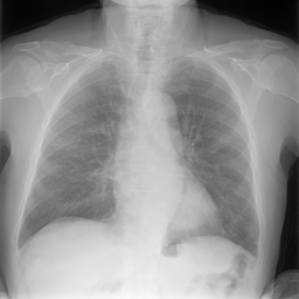

1/1 [==============================] - 0s 19ms/step
Predicted Label: COVID


In [ ]:
from google.colab import files
from google.colab.patches import cv2_imshow
import cv2

# Upload image file
uploaded = files.upload()

# Check if any file is uploaded
if len(uploaded.keys()) == 0:
    print("Error: No file uploaded")
    exit()

# Get the filename of the uploaded file
filename = list(uploaded.keys())[0]

# Read the uploaded image
uploaded_image = cv2.imread(filename)

# Display the uploaded image
cv2_imshow(uploaded_image)

# Preprocess the uploaded image
# Convert to grayscale
gray_image = cv2.cvtColor(uploaded_image, cv2.COLOR_BGR2GRAY)
# Resize the image to match the input size of the model (64x64)
resized_image = cv2.resize(gray_image, (64, 64))
# Reshape the image to add the channel dimension (1 for grayscale)
input_image = resized_image.reshape((1, 64, 64, 1))
# Normalize the pixel values
input_image = input_image.astype('float32') / 255

# Make prediction using the model
prediction = cnn_model1.predict(input_image)

# Get the predicted class label
predicted_class = np.argmax(prediction)

# Decode the predicted class label
class_labels = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
predicted_label = class_labels[predicted_class]

# Print the predicted label
print("Predicted Label:", predicted_label)


Saving COVID.png to COVID.png


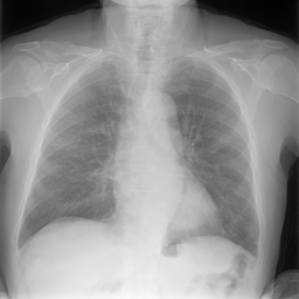

1/1 [==============================] - 0s 368ms/step
Predicted Label: COVID


In [ ]:
from google.colab import files
from google.colab.patches import cv2_imshow
import cv2

# Upload image file
uploaded = files.upload()

# Check if any file is uploaded
if len(uploaded.keys()) == 0:
    print("Error: No file uploaded")
    exit()

# Get the filename of the uploaded file
filename = list(uploaded.keys())[0]

# Read the uploaded image
uploaded_image = cv2.imread(filename)

# Display the uploaded image
cv2_imshow(uploaded_image)

# Preprocess the uploaded image
# Convert to grayscale
gray_image = cv2.cvtColor(uploaded_image, cv2.COLOR_BGR2GRAY)
# Resize the image to match the input size of the model (64x64)
resized_image = cv2.resize(gray_image, (64, 64))
# Reshape the image to add the channel dimension (1 for grayscale)
input_image = resized_image.reshape((1, 64, 64, 1))
# Normalize the pixel values
input_image = input_image.astype('float32') / 255

# Make prediction using the model
prediction = loaded_model.predict(input_image)

# Get the predicted class label
predicted_class = np.argmax(prediction)

# Decode the predicted class label
class_labels = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
predicted_label = class_labels[predicted_class]

# Print the predicted label
print("Predicted Label:", predicted_label)
